In [1]:
# imports
import h5py
import wandb
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
# Read the dataset
dataset_file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5", "r")

# Base modulation classes
base_modulation_classes = [
    'OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
    '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
    'FM', 'GMSK', 'OQPSK'
]

# Selected modulation classes
selected_modulation_classes = [
    '4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK'
]

# Get the indices of selected modulation classes
selected_classes_id = [base_modulation_classes.index(cls) for cls in selected_modulation_classes]

In [3]:
# Model

class SEBlock(nn.Module):
    """ Squeeze-and-Excitation Block """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

class MultiHeadAttention(nn.Module):
    """ Multi-Head Attention Module """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return attn_output

class RadioNet(nn.Module):
    def __init__(self, num_classes):
        super(RadioNet, self).__init__()

        # Separate Convolutional Pathways for I and Q
        self.q_conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SEBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            SEBlock(256),
            nn.MaxPool2d(2, stride=2)
        )

        self.i_conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SEBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            SEBlock(256),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_size = self._get_conv_output((1, 32, 32))

        # Bidirectional LSTM with Layer Normalization
        self.lstm = nn.LSTM(self.feature_size * 2, 512, num_layers=2, 
                            batch_first=True, bidirectional=True, dropout=0.3)
        self.layer_norm = nn.LayerNorm(1024)  # Layer normalization after LSTM

        # Multi-Head Attention with multiple heads
        self.multi_head_attn = MultiHeadAttention(1024, num_heads=8)

        # Enhanced Fully Connected Layers with Dense Connections
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.1)
        )

        self.output = nn.Linear(64, num_classes)

    def _get_conv_output(self, shape):
        input = torch.rand(1, *shape)
        output = self.q_conv(input)
        return int(torch.numel(output) / output.shape[0])

    def forward(self, i_input, q_input):
        q = self.q_conv(q_input)
        q = q.view(q.size(0), -1)

        i = self.i_conv(i_input)
        i = i.view(i.size(0), -1)

        combined = torch.cat((q, i), dim=1)
        combined = combined.unsqueeze(1)  # Add sequence dimension

        lstm_out, _ = self.lstm(combined)
        lstm_out = self.layer_norm(lstm_out)

        # Apply Multi-Head Attention
        attn_output = self.multi_head_attn(lstm_out)
        context = torch.sum(attn_output, dim=1)  # Sum up the attended output

        x = self.fc(context)
        x = self.output(x)

        return torch.log_softmax(x, dim=1)

def create_model(num_classes):
    model = RadioNet(num_classes)
    learning_rate = 0.0003
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    return model, optimizer, loss_fn, scheduler

In [4]:
# Initialize model, optimizer, and loss function
num_classes = len(selected_modulation_classes)
model, optimizer, loss_fn, scheduler = create_model(num_classes)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# Check if multiple GPUs are available and use them if possible
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    # Wrap the model with DataParallel to parallelize across available GPUs
    model = nn.DataParallel(model)

# Set device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

RadioNet(
  (q_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): SEBlock(
      (se): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
    )
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)

In [6]:
# Number of SNRs (from 30 SNR to 22 SNR)
N_SNR = 4 

# Initialize placeholders for data
X_data = None
y_data = None

# Loop through selected modulation classes
for id in selected_classes_id:
    # Load data slices based on indices
    X_slice = dataset_file['X'][(106496*(id+1) - 4096*N_SNR) : 106496*(id+1)]
    y_slice = dataset_file['Y'][(106496*(id+1) - 4096*N_SNR) : 106496*(id+1)]
    
    # Concatenate the slices to build the dataset
    if X_data is not None:
        X_data = np.concatenate([X_data, X_slice], axis=0)
        y_data = np.concatenate([y_data, y_slice], axis=0)
    else:
        X_data = X_slice
        y_data = y_slice

# Reshape the X_data to the required shape (e.g., 32x32 with 2 channels)
X_data = X_data.reshape(len(X_data), 32, 32, 2)

# Convert y_data to a DataFrame for easier manipulation
y_data_df = pd.DataFrame(y_data)

# Drop columns where the sum is 0 (i.e., no modulation class data in that column)
for column in y_data_df.columns:
    if sum(y_data_df[column]) == 0:
        y_data_df = y_data_df.drop(columns=[column])

# Assign the remaining columns to match the selected modulation classes
y_data_df.columns = selected_modulation_classes

# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_df, test_size=0.2)

In [7]:
# Define the custom Dataset class
class RadioMLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float().to(device)  # Convert X to a PyTorch tensor
        self.y = torch.from_numpy(y.values).float().to(device)  # Convert y to a PyTorch tensor
    
    def __len__(self):
        return len(self.X)  # Return the number of samples in the dataset
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # Return a sample and its corresponding label

# Create Dataset objects for training and testing data
train_dataset = RadioMLDataset(X_train, y_train)
test_dataset = RadioMLDataset(X_test, y_test)

# Create DataLoader objects for batching and shuffling data
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for test data

# Example of how to use the DataLoader
for batch_X, batch_y in train_loader:
    # batch_X and batch_y are PyTorch tensors
    # batch_X shape: (batch_size, 32, 32, 2)
    # batch_y shape: (batch_size, num_classes)
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Batch y shape: {batch_y.shape}")
    break  # This breaks the loop after the first batch, just to demonstrate

Batch X shape: torch.Size([32, 32, 32, 2])
Batch y shape: torch.Size([32, 8])


In [8]:
# Training parameters
epochs = 50
patience = 10
best_acc = 0
no_improve = 0
path_checkpoint = "model_checkpoint.pth"

# Training loop
train_losses, train_accs, val_losses, val_accs = [], [], [], []

In [9]:
# wandb login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key") 
wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
# Initialize wandb
wandb.init(project="RadioML", name="RadioNetE50")

# Log model architecture
wandb.watch(model)

for epoch in range(epochs):
    # Set model to training mode
    model.train()
    train_loss, train_correct = 0, 0
    # Training loop
    for batch_X, batch_y in train_loader:
        # Split the input into I and Q components
        i_input = batch_X[:, :, :, 0].unsqueeze(1)  # I component
        q_input = batch_X[:, :, :, 1].unsqueeze(1)  # Q component
        # Zero out the gradients
        optimizer.zero_grad()
        # Forward pass through the model
        outputs = model(i_input, q_input)
        # Compute loss
        loss = loss_fn(outputs, batch_y)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Accumulate training loss and correct predictions
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == batch_y.argmax(1)).sum().item()
    # Compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_dataset)
    # Validation loop (without gradient updates)
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            # Split the input into I and Q components
            i_input = batch_X[:, :, :, 0].unsqueeze(1)  # I component
            q_input = batch_X[:, :, :, 1].unsqueeze(1)  # Q component
            # Forward pass through the model
            outputs = model(i_input, q_input)
            # Compute validation loss
            val_loss += loss_fn(outputs, batch_y).item()
            # Accumulate correct predictions
            val_correct += (outputs.argmax(1) == batch_y.argmax(1)).sum().item()
    # Compute average validation loss and accuracy
    val_loss /= len(test_loader)
    val_acc = val_correct / len(test_dataset)
    # Save loss and accuracy for later plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Print progress for this epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    # Step the learning rate scheduler based on validation loss
    scheduler.step(val_loss)
    # Early stopping and model checkpointing
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), path_checkpoint)  # Save the model checkpoint
        wandb.save(path_checkpoint)  # Save the model checkpoint to wandb
        no_improve = 0  # Reset no improvement counter
    else:
        no_improve += 1
        if no_improve == patience:
            print("Early stopping")
            break

# Finish the wandb run
wandb.finish()

wandb: Currently logged in as: devcode03 (devcode03-gujarat-technological-university). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240909_025043-annmf5ah
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run RadioNetE50
wandb: ⭐️ View project at https://wandb.ai/devcode03-gujarat-technological-university/RadioML
wandb: 🚀 View run at https://wandb.ai/devcode03-gujarat-technological-university/RadioML/runs/annmf5ah


Epoch 1/50, Train Loss: 0.8519, Train Acc: 0.5875, Val Loss: 0.7792, Val Acc: 0.6084
Epoch 2/50, Train Loss: 0.5791, Train Acc: 0.7395, Val Loss: 0.6435, Val Acc: 0.7267
Epoch 3/50, Train Loss: 0.5055, Train Acc: 0.7762, Val Loss: 0.4381, Val Acc: 0.8075
Epoch 4/50, Train Loss: 0.4800, Train Acc: 0.7863, Val Loss: 0.4312, Val Acc: 0.8129
Epoch 5/50, Train Loss: 0.4399, Train Acc: 0.7972, Val Loss: 0.3583, Val Acc: 0.8298
Epoch 6/50, Train Loss: 0.3627, Train Acc: 0.8378, Val Loss: 0.3067, Val Acc: 0.8619
Epoch 7/50, Train Loss: 0.3432, Train Acc: 0.8489, Val Loss: 0.3225, Val Acc: 0.8617
Epoch 8/50, Train Loss: 0.3239, Train Acc: 0.8574, Val Loss: 0.2620, Val Acc: 0.8856
Epoch 9/50, Train Loss: 0.3193, Train Acc: 0.8609, Val Loss: 0.3753, Val Acc: 0.8387
Epoch 10/50, Train Loss: 0.3050, Train Acc: 0.8659, Val Loss: 0.2774, Val Acc: 0.8751
Epoch 11/50, Train Loss: 0.2980, Train Acc: 0.8696, Val Loss: 0.2459, Val Acc: 0.8939
Epoch 12/50, Train Loss: 0.3010, Train Acc: 0.8705, Val Loss: 0

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb: learning_rate ██████████████████████████████▂▂▂▂▂▁▁▁▁▁
wandb:     train_acc ▁▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
wandb:    train_loss █▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:       val_acc ▁▃▅▅▆▆▇▆▇▇▇▇▇▇▇▇████████████████████████
wandb:      val_loss █▇▄▄▃▃▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂
wandb: 
wandb: Run summary:
wandb:         epoch 50
wandb: learning_rate 0.0
wandb:     train_acc 0.99775
wandb:    train_loss 0.00691
wandb:       val_acc 0.95358
wandb:      val_loss 0.22949
wandb: 
wandb: 🚀 View run RadioNetE50 at: https://wandb.ai/devcode03-gujarat-technological-university/RadioML/runs/annmf5ah
wandb: ⭐️ View project at: https://wandb.ai/devcode03-gujarat-technological-university/RadioML
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs

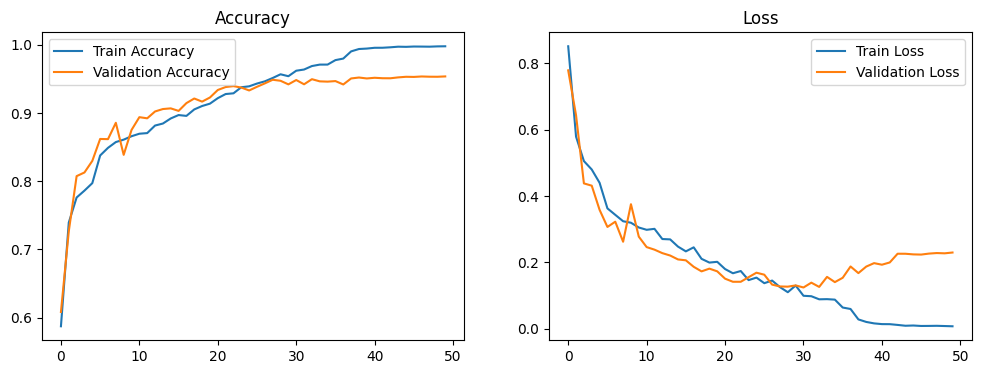

In [11]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

/tmp/ipykernel_25/3696326460.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_checkpoint))


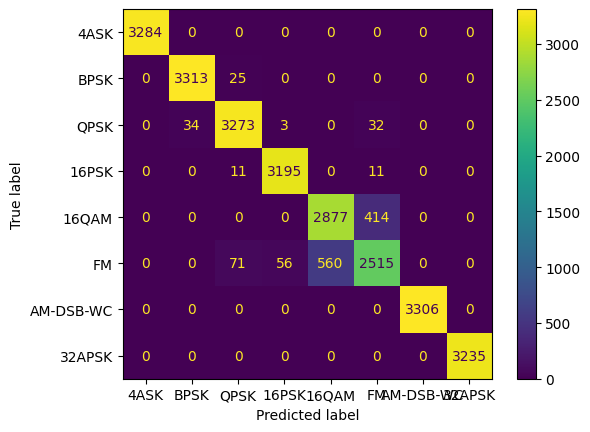

In [12]:
# Model predictions and confusion matrix
model.load_state_dict(torch.load(path_checkpoint))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        i_input, q_input = batch_X[:, :, :, 0].unsqueeze(1), batch_X[:, :, :, 1].unsqueeze(1)
        outputs = model(i_input, q_input)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(batch_y.argmax(1).cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_modulation_classes)
disp.plot()
plt.show()

In [13]:
# Save and load model
torch.save(model.state_dict(), '/kaggle/working/CNN_LSTMmodel.pth')
loaded_model, _, _, _ = create_model(num_classes)
loaded_model.load_state_dict(torch.load('/kaggle/working/CNN_LSTMmodel.pth'))

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_25/2769534498.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of th

<All keys matched successfully>

In [14]:
# Evaluate loaded model
loaded_model.eval()
loaded_model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        i_input, q_input = batch_X[:, :, :, 0].unsqueeze(1), batch_X[:, :, :, 1].unsqueeze(1)
        outputs = loaded_model(i_input, q_input)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y.argmax(1)).sum().item()

print('Restored model, accuracy: {:.2f}%'.format(100 * correct / total))

Restored model, accuracy: 95.36%
